# <div style="text-align: center;"> **CNN MODELS** </div>

----------------------------

In [7]:
import os
import sys
sys.path.append(os.path.abspath('../scr'))
from create_directories import create_directories
from copy_images import copy_images
from image_loader import LoadImage
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

### **Create the directories**

In [4]:
#Set the directory with the folders fracture and nofracture
base_path = "../Data/Processed/ml-dp"

create_directories(base_path)

### **Copy images to the new directories**

In [5]:
#Print the length of fracture and nofracture directories
fracture = "../Data/Processed/ml-dp/fracture"
nofracture = "../Data/Processed/ml-dp/nofracture"

print("Length of fracture's images:", len(os.listdir(fracture)))
fraction_fracture = 0.8 * len(os.listdir(fracture))
print("Number of fracture's images in train:", 0.8 * fraction_fracture)
print("Number of fracture's images in validation:", 0.2 * fraction_fracture)
print("Number of fracture's images in test:", 0.2 * len(os.listdir(fracture)))

print("Length of nofracture's images:", len(os.listdir(nofracture)))
fraction_nofracture = 0.8 * len(os.listdir(nofracture))
print("Number of nofracture's images in train:", 0.8 * fraction_nofracture)
print("Number of nofracture's images in validation:", 0.2 * fraction_nofracture)
print("Number of nofracture's images in test:", 0.2 * len(os.listdir(nofracture)))


Length of fracture's images: 1935
Number of fracture's images in train: 1238.4
Number of fracture's images in validation: 309.6
Number of fracture's images in test: 387.0
Length of nofracture's images: 1902
Number of nofracture's images in train: 1217.2800000000002
Number of nofracture's images in validation: 304.32000000000005
Number of nofracture's images in test: 380.40000000000003


In [6]:
#Copy images from fractures to train/fractures
copy_images("../Data/Processed/ml-dp/fracture", "../Data/Processed/ml-dp/train/fracture", 0, 1238)
#Copy images from fractures to val/fracture
copy_images("../Data/Processed/ml-dp/fracture", "../Data/Processed/ml-dp/val/fracture", 1238, 1548)
#Copy images from fractures to test/fracture
copy_images("../Data/Processed/ml-dp/fracture", "../Data/Processed/ml-dp/test/fracture", 1548, 1935)

#Copy images from nofractures to train/nofractures
copy_images("../Data/Processed/ml-dp/nofracture", "../Data/Processed/ml-dp/train/nofracture", 0, 12178)
#Copy images from nofractures to val/nofracture
copy_images("../Data/Processed/ml-dp/nofracture", "../Data/Processed/ml-dp/val/nofracture", 1217, 1522)
#Copy images from nofractures to test/nofracture
copy_images("../Data/Processed/ml-dp/nofracture", "../Data/Processed/ml-dp/test/nofracture", 1522, 1902)

1238 copied from ../Data/Processed/ml-dp/fracture to ../Data/Processed/ml-dp/train/fracture
310 copied from ../Data/Processed/ml-dp/fracture to ../Data/Processed/ml-dp/val/fracture
387 copied from ../Data/Processed/ml-dp/fracture to ../Data/Processed/ml-dp/test/fracture
1902 copied from ../Data/Processed/ml-dp/nofracture to ../Data/Processed/ml-dp/train/nofracture
305 copied from ../Data/Processed/ml-dp/nofracture to ../Data/Processed/ml-dp/val/nofracture
380 copied from ../Data/Processed/ml-dp/nofracture to ../Data/Processed/ml-dp/test/nofracture


### **Load and Preprocessing images**

In [15]:
#Create a generator to preprocessing images using the class ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255, #normalizing images
    rotation_range=10, #rotating images 10º
    width_shift_range=0.1, #traslating images 10%
    height_shift_range=0.1, #traslating images 10%
    zoom_range=0.1, #10% zoom
    horizontal_flip=True) 

val_datagen = ImageDataGenerator(
    rescale=1./255
    )

test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [17]:
#Load and preprocessing images
train_dir = "../Data/Processed/ml-dp/train"
val_dir = "../Data/Processed/ml-dp/val"
test_dir = "../Data/Processed/ml-dp/test"

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (256, 256),
    batch_size = 20,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (256, 256),
    batch_size = 20,
    class_mode='binary',
    shuffle=False #images are loading in the original order
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (256, 256),
    batch_size = 20,
    class_mode='binary',
    shuffle=False
)

Found 3140 images belonging to 2 classes.
Found 615 images belonging to 2 classes.
Found 767 images belonging to 2 classes.


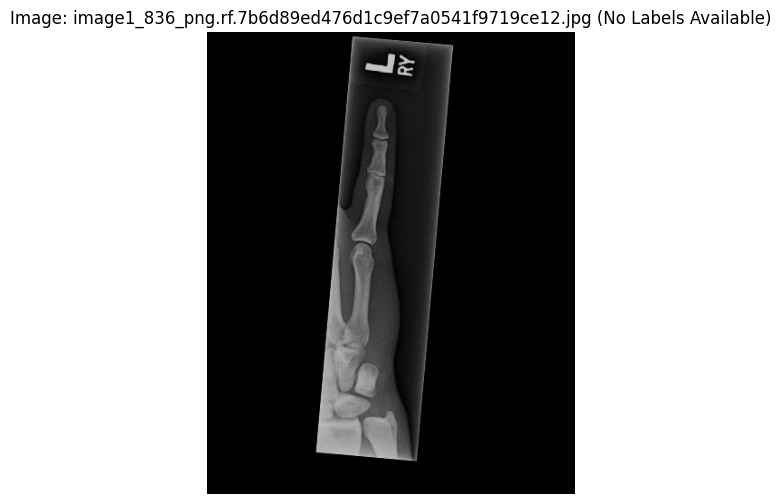

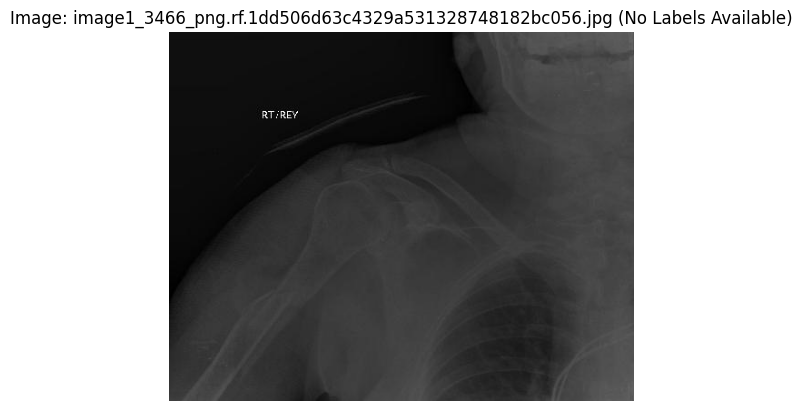

In [18]:
#Plot random images
loader = LoadImage(train_dir)
loader.plot_images_with_bboxes() 


----------------

### **Construct a CNN**

In [19]:
#Construct the model 
model = models.Sequential()
#First layer with teh image format (resolution and channels)
model.add(layers.Input(shape=(256, 256, 3))) 
#Convolution layer with 32 kernels 3x3, activation function relu
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
#Reducing dimesionality wits a MaxPooling 2x2
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#Convert the characteristics to an unidemintional vector before construct the Dense layer
model.add(layers.Flatten())
#Desnse layer or fully connected layer with 512 neurons
model.add(layers.Dense(512, activation='relu'))
#To prevent overfitting, 50% of neurons will be out randomly during train
model.add(layers.Dropout(0.5))
#Las layer with 1 node (binary classification and a sigmoid activation)
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,079,553 (99.49 MB)

 Trainable params: 26,079,553 (99.49 MB)

 Non-trainable params: 0 (0.00 B)

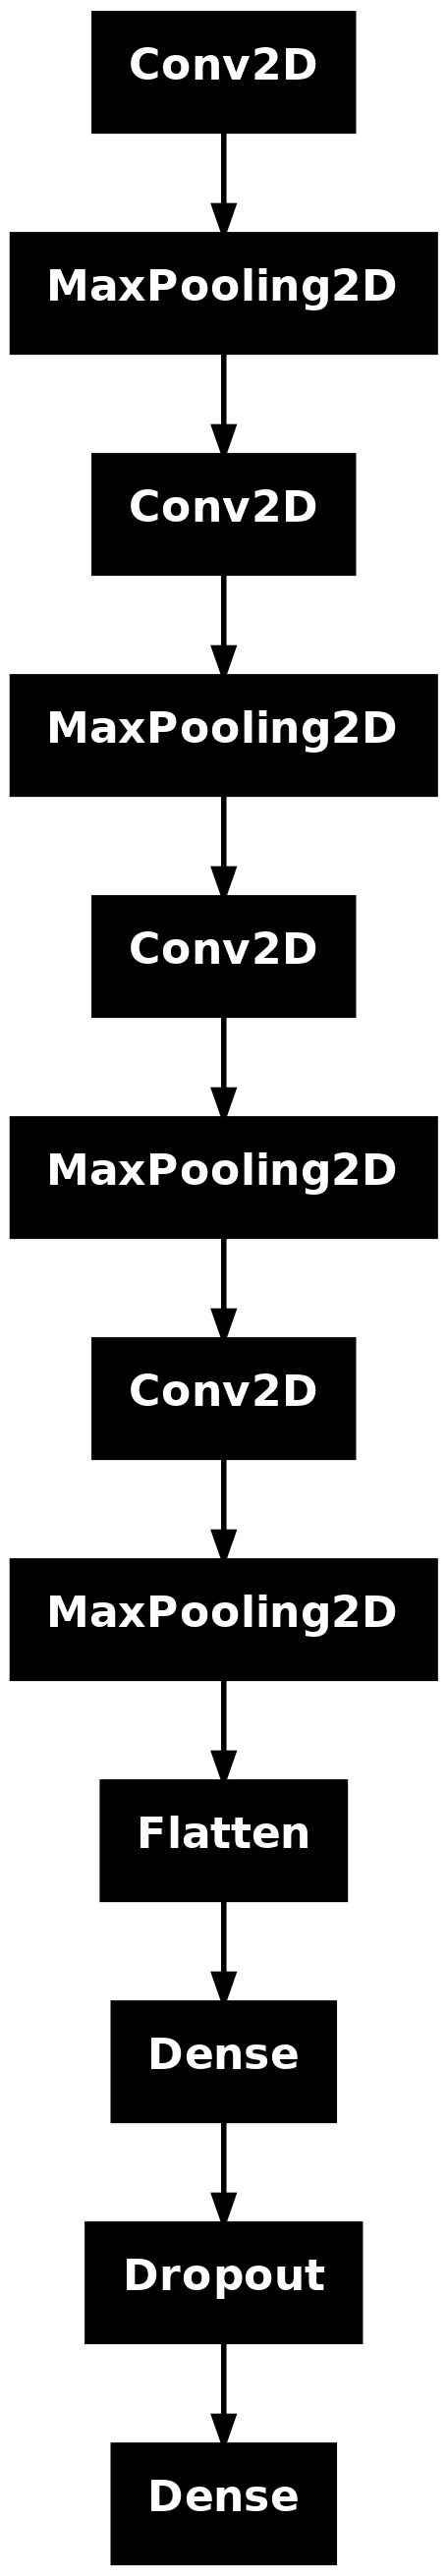

In [20]:
tf.keras.utils.plot_model(model)

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #learning rate 0.001

In [22]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,         
    patience=3,          
    min_lr=1e-6
)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',      
    patience=10,              
    restore_best_weights=True  
)

#Train the model 
history = model.fit(
    train_generator,
    steps_per_epoch = 150, #numer of imagen in each epoch
    epochs = 100,                
    validation_data = val_generator,
    callbacks=[reduce_lr, early_stopping]  
)

/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1731419675.923603  132532 service.cc:148] XLA service 0x7f5f98004350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731419675.923624  132532 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-11-12 14:54:35.974014: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731419676.168268  132532 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-12 14:54:36.553483: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,32,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,3,256,256]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"

  2/150 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6125 - loss: 1.1051 

I0000 00:00:1731419680.100199  132532 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.5884 - loss: 0.7372

/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-11-12 14:55:10.262300: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,32,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,3,256,256]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues"

150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 221ms/step - accuracy: 0.5885 - loss: 0.7369 - val_accuracy: 0.4959 - val_loss: 0.7257 - learning_rate: 0.0010
Epoch 2/100


2024-11-12 14:55:12.915134: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2024-11-12 14:55:13.009626: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.


  7/150 ━━━━━━━━━━━━━━━━━━━━ 24s 175ms/step - accuracy: 0.6777 - loss: 0.6469

2024-11-12 14:55:14.151823: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-12 14:55:14.151853: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-11-12 14:55:14.151863: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6800203878100376487
2024-11-12 14:55:14.151872: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5328484328347029209
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, trace

150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6445 - loss: 0.6595 - val_accuracy: 0.4959 - val_loss: 0.7533 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 206ms/step - accuracy: 0.5934 - loss: 0.6797 - val_accuracy: 0.4959 - val_loss: 0.6968 - learning_rate: 0.0010
Epoch 4/100
  2/150 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6500 - loss: 0.7127

2024-11-12 14:55:45.817674: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.


  7/150 ━━━━━━━━━━━━━━━━━━━━ 23s 168ms/step - accuracy: 0.6494 - loss: 0.6741

2024-11-12 14:55:46.922388: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6364 - loss: 0.6551 - val_accuracy: 0.4959 - val_loss: 0.7408 - learning_rate: 0.0010
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 208ms/step - accuracy: 0.6014 - loss: 0.6743 - val_accuracy: 0.4959 - val_loss: 0.7022 - learning_rate: 0.0010
Epoch 6/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 24s 174ms/step - accuracy: 0.6167 - loss: 0.6577

2024-11-12 14:56:20.038977: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6800203878100376487
2024-11-12 14:56:20.039005: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5328484328347029209


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6144 - loss: 0.6594 - val_accuracy: 0.4959 - val_loss: 0.7052 - learning_rate: 0.0010
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.6037 - loss: 0.6632 - val_accuracy: 0.4959 - val_loss: 0.7062 - learning_rate: 5.0000e-04
Epoch 8/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - accuracy: 0.6171 - loss: 0.6763

2024-11-12 14:56:52.562466: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6076 - loss: 0.6658 - val_accuracy: 0.4959 - val_loss: 0.6943 - learning_rate: 5.0000e-04
Epoch 9/100


2024-11-12 14:56:53.467791: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 203ms/step - accuracy: 0.6136 - loss: 0.6572 - val_accuracy: 0.4959 - val_loss: 0.6847 - learning_rate: 5.0000e-04
Epoch 10/100
  2/150 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.5125 - loss: 0.7072

2024-11-12 14:57:24.034180: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.


  7/150 ━━━━━━━━━━━━━━━━━━━━ 23s 166ms/step - accuracy: 0.5471 - loss: 0.7023

2024-11-12 14:57:25.127868: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6800203878100376487
2024-11-12 14:57:25.127894: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5328484328347029209


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5567 - loss: 0.6948 - val_accuracy: 0.4992 - val_loss: 0.6821 - learning_rate: 5.0000e-04
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 202ms/step - accuracy: 0.6108 - loss: 0.6655 - val_accuracy: 0.4959 - val_loss: 0.6979 - learning_rate: 5.0000e-04
Epoch 12/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 24s 169ms/step - accuracy: 0.5635 - loss: 0.6676

2024-11-12 14:57:57.430938: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6800203878100376487
2024-11-12 14:57:57.430966: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5328484328347029209


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5779 - loss: 0.6766 - val_accuracy: 0.4959 - val_loss: 0.6983 - learning_rate: 5.0000e-04
Epoch 13/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.5897 - loss: 0.6682 - val_accuracy: 0.4959 - val_loss: 0.7135 - learning_rate: 5.0000e-04
Epoch 14/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 23s 166ms/step - accuracy: 0.5384 - loss: 0.6909

2024-11-12 14:58:30.326695: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6800203878100376487
2024-11-12 14:58:30.326742: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5328484328347029209


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5631 - loss: 0.6674 - val_accuracy: 0.4959 - val_loss: 0.7152 - learning_rate: 2.5000e-04
Epoch 15/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.6137 - loss: 0.6535 - val_accuracy: 0.5057 - val_loss: 0.6817 - learning_rate: 2.5000e-04
Epoch 16/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - accuracy: 0.6294 - loss: 0.6577

2024-11-12 14:59:02.928283: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-11-12 14:59:02.928312: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6800203878100376487
2024-11-12 14:59:02.928327: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5328484328347029209


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6286 - loss: 0.6600 - val_accuracy: 0.5041 - val_loss: 0.6860 - learning_rate: 2.5000e-04
Epoch 17/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 206ms/step - accuracy: 0.5977 - loss: 0.6574 - val_accuracy: 0.5431 - val_loss: 0.6844 - learning_rate: 2.5000e-04
Epoch 18/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 24s 170ms/step - accuracy: 0.5816 - loss: 0.6611

2024-11-12 14:59:35.824733: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6800203878100376487
2024-11-12 14:59:35.824760: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5328484328347029209


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6128 - loss: 0.6552 - val_accuracy: 0.5447 - val_loss: 0.6863 - learning_rate: 2.5000e-04
Epoch 19/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 203ms/step - accuracy: 0.6132 - loss: 0.6511 - val_accuracy: 0.5220 - val_loss: 0.7023 - learning_rate: 1.2500e-04
Epoch 20/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step - accuracy: 0.6563 - loss: 0.6130

2024-11-12 15:00:08.115728: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6800203878100376487
2024-11-12 15:00:08.115758: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5328484328347029209


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6707 - loss: 0.6142 - val_accuracy: 0.5220 - val_loss: 0.7244 - learning_rate: 1.2500e-04
Epoch 21/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.6164 - loss: 0.6402 - val_accuracy: 0.5268 - val_loss: 0.6941 - learning_rate: 1.2500e-04
Epoch 22/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 24s 171ms/step - accuracy: 0.6672 - loss: 0.6306

2024-11-12 15:00:40.763406: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6800203878100376487
2024-11-12 15:00:40.763433: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5328484328347029209


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6304 - loss: 0.6387 - val_accuracy: 0.5252 - val_loss: 0.6953 - learning_rate: 6.2500e-05
Epoch 23/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 207ms/step - accuracy: 0.6267 - loss: 0.6373 - val_accuracy: 0.5366 - val_loss: 0.6843 - learning_rate: 6.2500e-05
Epoch 24/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 25s 176ms/step - accuracy: 0.5957 - loss: 0.6543

2024-11-12 15:01:13.743544: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6800203878100376487
2024-11-12 15:01:13.743571: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5328484328347029209


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5726 - loss: 0.6727 - val_accuracy: 0.5382 - val_loss: 0.6838 - learning_rate: 6.2500e-05
Epoch 25/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.6343 - loss: 0.6394 - val_accuracy: 0.5350 - val_loss: 0.6834 - learning_rate: 3.1250e-05


### *Model graphs*

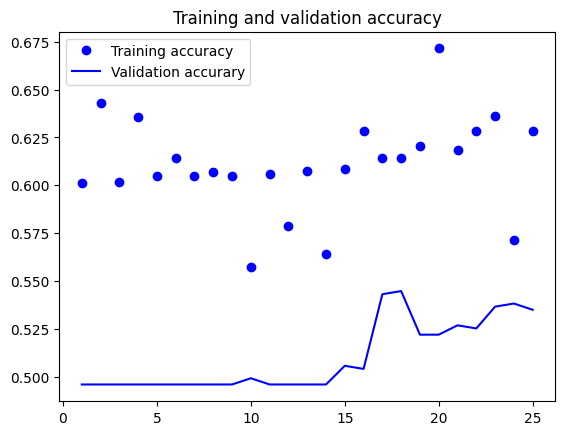

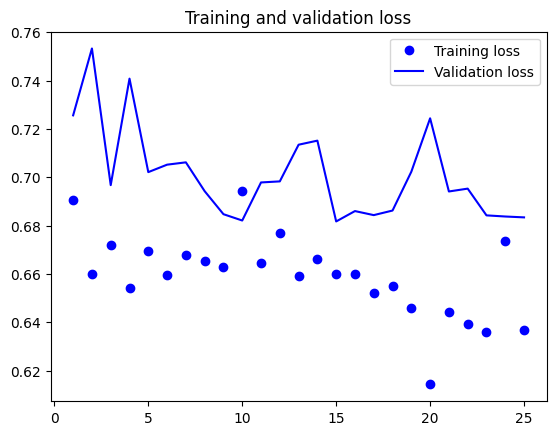

In [24]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Defuning the epochs of the model (from 1 to len(train_acc) + 1)
epochs = range(1, len(train_acc)+1)

#Creating the accuracy plot
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accurary')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
# Creating the loss plot
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# mostramos gráfico
plt.show()

#train_dir = "../1-Data/ml-dp/train"
loader = LoadImage(train_dir)

images_train = loader.images
names_train = loader.names

print(f"Number of images: {len(images_train)}") 
loader.plot_images_with_bboxes() 

loader = LoadImage(image_path='/ruta/a/imagenes', label_path='/ruta/a/labels')

#Train
preprocessor_train = PreprocessImage(images_train) 
resized_images_train, _ = preprocessor_train.resize_images_and_labels() #_ indicates that we don't have labels

resized_preprocessor_train = PreprocessImage(resized_images_train)
gray_images_train = resized_preprocessor_train.convert_to_grayscale()

normalized_preprocessor_train = PreprocessImage(gray_images_train)
normalized_images_train = normalized_preprocessor_train.normalize_images()

preprocessor = PreprocessImage(images, labels)
resized_images, labels = preprocessor.resize_images_and_labels()